# Hogyan hatott a COVID a NYC sárgataxi-utakra?
A COVID az élet minden területét erősen érintette, ebből pedig a New York-i taxiforgalom sem maradhatott ki. Ebben a notebook-ban összehasonlítjuk a New York-i sárga taxiutak jellemzőit a COVID előtti (2019-es év) és a COVID közbeni/utáni (2020-es év) időszakban. A feladatunk a következőkből fog állni: először is kifejtő adatelemzést végzünk az adatokon az adattisztítást követően, majd megjelenítjük az adatokat térképen is interaktív módon, végül pedig egy regressziós modellt illesztünk az adatokra, hogy prediktálni tudjuk borravaló mértékét bizonyos jellemzők alapján.

Az adatokat az alábbi [linkről](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) lehet letölteni. Ahhoz, hogy az notebook helyesen tudjon futni, három mappának kell szerepelnie a notebook mappájában. Az első neve `2019`, ebbe kell elhelyezni a letöltött 2019-es adatok 12 darab parquet fájlját. A második `2020`, ebbe is a névnek megfelelő 12 parquet fájl kerül. Végül pedig az `sum` nevű mappára van szükség, amiben az összesített éves adatok fognak bekerülni a program által.

Egyszerűbb alternatíva a `download.py` futtatása, ami mindezt automatikusan megteszi nekünk.

In [1]:
import pandas as pd
import plotly.express as px

## Adatok beolvasása és szűrése
Először beolvassuk a 2019-as adatokat hónaponként, egy listába tesszük őket és szűrjük őket. Majd ugyanezeket a lépéseket megtesszük a 2020-as adatokkal is. Minden hónapból az adatok hetedrészét használjuk fel, hogy a hatalmas mennyiségű adattal tudjunk dolgozni.

Pár oszlopnál tapasztaltunk rendkívül magas/alacsony értékeket (például 2088-as dátum).
Az alábbi szűrési lépéseket tettük meg:

* A dátumoknál meghatároztuk, hogy az adott hónap időkeretében kell lennie a `tpep_pickup_datetime` és a `tpep_dropoff_datetime`-nak.
    * Az is fontos, hogy a `tpep_pickup_datetime` ne legyen előbb mint a `tpep_dropoff_datetime`.
* A `passenger_count` minimum 1 és maximum 6 lehet, mivel ezt írja elő a törvény.
* A `trip_distance` egy pozitív szám, ami kisebb, mint New York átmérője.
* Összesen 263 körzet van, ezért a  `PULocationID` és a `DOLocationID` minimum 1 és maximum 263 lehet.
* A `fare_amount` minimum 2.5\\$.
* Az `extra` 0\\$, 0.5\\$, 1\\$ 2.5\\$, 3\\$ vagy 3.5\\$ lehet.
* A `tip_amount` nem lehet negatív, és a `fare_amount` nem lehet nagyobb, mint a `total_amount`.
* Felső korlátnak, csak megadtuk, hogy a 99.99-es percentillisig szűrjön a `fare_amount`, `tip_amount` és a `total_amount` oszlopoknál.

In [ ]:
from calendar import monthrange

filtered_month_dict = { 2019: [], 2020: [] }

for year in (2019, 2020):
    for month in range(1, 13):
        monthly_data = pd.read_parquet(
            path=f'{year}/{year}-{month:02d}.parquet',
            columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
                     'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
                     'fare_amount', 'extra', 'tip_amount', 'total_amount']
        )

        filter_columns = ['passenger_count', 'trip_distance', 'fare_amount',
                          'extra', 'tip_amount', 'total_amount']

        percentile = 0.9999

        filter_string = ' & '.join(
            (
                f'("{year}, {month}, 1" <= tpep_pickup_datetime)',
                f'(tpep_pickup_datetime <= "{year}, {month}, {monthrange(year, month)[1]}")',
                f'("{year}, {month}, 1" <= tpep_dropoff_datetime)',
                f'(tpep_dropoff_datetime <= "{year}, {month}, {monthrange(year, month)[1]}")',
                '(tpep_pickup_datetime <= tpep_dropoff_datetime)',
                '(1 <= passenger_count) & (passenger_count <= 6)',
                '(0 < trip_distance) & (trip_distance <= 330)',
                '(1 <= PULocationID) & (PULocationID <= 263)',
                '(1 <= DOLocationID) & (DOLocationID <= 263)',
                '(2.5 <= fare_amount)',
                '(extra in (0, 0.5, 1, 2.5, 3, 3.5))',
                '(0 <= tip_amount)',
                '(fare_amount <= total_amount)',
                *(f'({column} <= {column}.quantile({percentile}))' for column in filter_columns)
            )
        )

        filtered_month_dict[year].append(
            monthly_data
            .sample(n=len(monthly_data) // 7)
            .query(filter_string)
        )

sum_2019 = pd.concat(filtered_month_dict[2019])
sum_2019.to_parquet('sum/sum_samp2019.parquet')

sum_2020 = pd.concat(filtered_month_dict[2020])
sum_2020.to_parquet('sum/sum_samp2020.parquet')

### Éves adatok összeillesztése az EDA-hoz
Összeillesztjük a két éves (2019 és 2020) adathalmazt, hogy elemezni tudjuk.

In [3]:
sum_filtered_2019 = pd.read_parquet('sum/sum_samp2019.parquet')
sum_filtered_2019['year'] = '2019'
sum_filtered_2019['hetvege'] = sum_filtered_2019['tpep_pickup_datetime'].dt.dayofweek > 5

sum_filtered_2020 = pd.read_parquet('sum/sum_samp2020.parquet')
sum_filtered_2020['year'] = '2020'
sum_filtered_2020['hetvege'] = sum_filtered_2020['tpep_pickup_datetime'].dt.dayofweek > 5

sum_filtered = pd.concat([sum_filtered_2019, sum_filtered_2020])

### Kártyás adatok szűrése
Leszűrjük az adatokat, hogy csak a kártyás fizetések jelenjenek meg. A borravaló vizsgálat szempontjából ugyanis csak a kártyás fizetésre van szükségünk, mivel csak azoknál mértek borravalót.

In [4]:
only_card_data = sum_filtered[sum_filtered.payment_type == 1]

## Kifejtő adatelemzés (EDA)

### Az utazás távolsága és az extra költségek kapcsolata
Ezen a ploton azt vizsgáljuk meg hogy hogyan függ az utazás távolsága az extra költségektől. Extra költség típusok: 0.50 overnight charge(8pm-6am), 1 rush hour charge(4pm-8pm), New York State Congestion Surcharge (Ha manhattan 96th útja déli részét érinti az út) of 2.50. Az utóbbit nem tartalmazza az adatszolgáltatók szerint, de az adatokból úgy tűnik, hogy tartalmazza.

A diagrammon az látszik hogy éjszaka hosszabb távon igényelték a taxikat mindkét évben, mint normál időpontokban. 2019-ben rush órákban rövidebb távot utaztak, mint normál, nem extra költésges időkben, míg ez 2020-ben pont fordítva volt. Itt pont az ellentettjére számítottunk, mert gondoltuk, hogy 2020-ban a munkahelyüktől távolabb élők nagyobb számban dolgoztak otthonról, mint a közelebb élők. A 96th utcát érintő taxizások hossza kicsivel rövidebb mint az azt nem érintőké.

In [ ]:
fig = px.box(
    sum_filtered
    .sample(n=10000)
    .sort_index(),
    x='extra',
    y='trip_distance',
    color='year'
)

fig.update_yaxes(type='log', tickformat='.2f')
fig

### A borravaló és extra költségek kapcsolata
Ezen a ploton a borravaló átlagos mennyiségét vizsgáljuk az extra költségek szempontjából. Ehhez a plothoz csak a kártyával fizetők adatait használtuk, mert csak náluk jelenítették meg a borravalót.

A ploton látható, hogy mind a rush órákban mind az éjszakai órákban a borravaló átlagos mennyisége nagyobb a normál órákhoz képest. A rush órákban és éjszakai órákban körülbelül ugyanannyi az átlagos borravaló. A 96th utcát érintő taxizásoknál nem volt nagy eltérés az azt nem érintőkhöz képest.

In [ ]:
fig = px.box(
    only_card_data
    .sample(n=10000)
    .sort_index(),
    x='extra',
    y='tip_amount',
    color='year'
)

fig.update_yaxes(type='log', tickformat='.2f')
fig

### A borravaló és út hosszának kapcsolata
Ezen a ploton a borravalót és a út hosszát hasonlítjuk össze. Sok egy sorban levő adat van, ezek a kerek mennyiségű borravalók miatt vannak. A 0 sorban azok az adatok vannak ahol nem adtak borravalót.

In [ ]:
fig = px.strip(
    only_card_data
    .sample(n=10000, random_state=123)
    .sort_index(),
    x='trip_distance',
    y='tip_amount',
    color='year'
)

fig

### A teljes összeg és extra költségek kapcsolata
Ezen a ploton a teljes összeget vizsgáljuk az extra költségektől függően. 
Ez esetben a a rush óráknál és az éjszakai óráknál körülbelül ugyanannyi az átlagos összköltség, ezekhez képest a normál órákban kevesebb. A 96th útot érintő és nem érintő utaknál megegyeznek a megfelelő adatok, kivéve 2019-ben az átlag nagyobb az utcát érintőknél rush órákban, mint az utcát nem érintőknél. 2019-ben minden esetben magasabb volt az átlagos összköltség mint 2020-ban.

In [ ]:
fig = px.box(
    sum_filtered
    .sample(n=10000)
    .sort_index(),
    x='extra',
    y='total_amount',
    color='year'
)

fig.update_yaxes(type='log', tickformat='.0f')
fig

In [ ]:
fig = px.box(
    sum_filtered
    .sample(n=10000, random_state=95)
    .sort_index(),
    x='extra',
    y='total_amount',
    color='year'
)

fig.update_yaxes(type='log', tickformat='.0f')
fig

### Átlagos vitelár vizsgálata
Ezen a ploton az átlagos fare amountot vizsgáljuk évenként. A fare amount a taxi óra által számított ár. Ebben nincsenek az extra költségek benne.
2019-ben magasabb volt az átlagos vitelár, mint 2020-ban.

In [ ]:
fig = px.histogram(
    sum_filtered
    .sample(n=100000)
    .sort_index(),
    x='year',
    y='fare_amount',
    color='year',
    color_discrete_sequence=px.colors.qualitative.Dark2,
    histfunc='avg'
)

fig

### Átlagos távolság vizsgálata
A vitelárhoz hasonlóan a távolság is átlagosan magasabb volt 2019-ben mint 2020-ban. Ez a kettő erősen összefügg mivel a fare amount jelentős része a távolságdíjból származik.

In [ ]:
fig = px.histogram(
    sum_filtered
    .sample(n=100000)
    .sort_index(),
    x='year',
    y='trip_distance',
    color='year',
    color_discrete_sequence=px.colors.qualitative.Dark2,
    histfunc='avg'
)

fig

### Utazások átlagos távolsága időhöz viszonyítva
Itt a idő során az utazások átlagos hosszát jelenítjük meg egy hisztogramon.

Azt láthatjuk, hogy az első lockdown idején kis csökkenés figyelhető meg az utak távolságában, valószínűleg mivel az emberek csak a szükségesebb helyekre mentek el, amik távolsága is kisebb lehetett.

In [ ]:
fig = px.histogram(
    sum_filtered
    .sample(n=400000)
    .sort_index(),
    x='tpep_pickup_datetime',
    y='trip_distance',
    histfunc='sum',
    nbins=200
)

fig

### Utazások összköltsége időre lebontva
Az utazások összköltségének hisztogramján tisztán kivehető a COVID okozta lockdown hatása, hiszen áprilisban, amikor a lezárások beindultak az USA-ban, úgy természetesen a taxiutak száma, és így a belőlük származó bevétel is számottevően csökkent.

In [ ]:
fig = px.histogram(
    sum_filtered
    .sample(n=400000)
    .sort_index(),
    x='tpep_pickup_datetime',
    y='total_amount',
    histfunc='sum',
    nbins=100
)

fig

### Hétvége és hétköznapok összevetése
A diagramon láthatjuk, hogy az embereket nem befolyásolja az, hogy hétvégén utaznak taxin, vagy hétköznap, a `total_amount` független ettől.

In [ ]:
fig = px.histogram(
    sum_filtered
    .sample(n=100000)
    .sort_index(),
    x='year',
    y='total_amount',
    color='hetvege',
    barmode='group',
    histfunc='avg'
)

fig

## Adatvizualizáció
Az `PULocationID` és a `DOLocationID` oszlopokban megadott New York-i körzetekre vetítve megjelenítjük a várostérképen az utazási adatokat először statikus, majd interaktív módon is.

In [15]:
import dask.dataframe as dd
import contextily as cx
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

### Adatok betöltése

Beolvassuk a 2019-es és 2020-as adatokból a körzet azonosítókat.

A rendkívül nagy adatmennyiséghez már nem elengendő a $Pandas$ használata, $Dask$ keretrenszerre lesz szükségünk.

In [ ]:
filter_string = ' & '.join(
    (
        '(1 <= PULocationID) & (PULocationID <= 263)',
        '(1 <= DOLocationID) & (DOLocationID <= 263)'
    )
)

pre_covid_data = dd.read_parquet(
    path='2019',
    columns=['PULocationID', 'DOLocationID']
)

covid_data = dd.read_parquet(
    path='2020',
    columns=['PULocationID', 'DOLocationID']
)

pre_covid_data = pre_covid_data.query(filter_string)
covid_data = covid_data.query(filter_string)

### Földrajzi adatok beolvasása

A földrajzi adatok kezelésére $GeoPandas$-t használunk.

In [ ]:
data = (
    gpd
    .read_file(
        filename='taxi_zones/taxi_zones.shp',
        ignore_fields=['Shape_Leng', 'Shape_Area', 'LocationID', 'borough']
    )
    .set_index('OBJECTID')
    .rename_axis('LocationID')
    .rename(columns={'zone': 'Zone'})
)

### Körzetadatok összegzése

Megszámoljuk minden körzetre a `PULocationID`-t és a `DOLocationID`-t, majd ezeket eltároljuk a `data` dataframe megfelelő oszlopában.

Hiányzó adatokat 1-re állítottuk, hogy ne legyen gond az osztásnál, valamint a logaritmus vételnél.

In [ ]:
data['PUFrequencyPrC'] = (
    pre_covid_data
    .PULocationID
    .value_counts()
    .compute()
    .reindex_like(data)
    .fillna(value=1)
)

data['DOFrequencyPrC'] = (
    pre_covid_data
    .DOLocationID
    .value_counts()
    .compute()
    .reindex_like(data)
    .fillna(value=1)
)

data['PUFrequencyC'] = (
    covid_data
    .PULocationID
    .value_counts()
    .compute()
    .reindex_like(data)
    .fillna(value=1)
)

data['DOFrequencyC'] = (
    covid_data
    .DOLocationID
    .value_counts()
    .compute()
    .reindex_like(data)
    .fillna(value=1)
)

### Differencia adatok képzése
Differencia képzéshez osztást használtunk, mivel nagyságrendbeli különbség volt az adatok között.

A szép kirajzolhatóság miatt az adatokokat logaritmikus skálával jelenítjük meg.

In [ ]:
data['PUDifference'] = np.log10(data['PUFrequencyC'] / data['PUFrequencyPrC'])
data['DODifference'] = np.log10(data['DOFrequencyC'] / data['DOFrequencyPrC'])

### Statikus kirajzolás
A térképeken a körzetekből kiinduló és a körzetekbe érkező utak mennyisége látható.

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(2, 2, figsize=(13, 13))

fig.tight_layout()

title_array = np.array(
    [['Pick Up Frequency Pre-Covid', 'Pick Up Frequency Covid'],
     ['Drop Off Frequency Pre-Covid', 'Drop Off Frequency Covid']]
)

colour_array = np.array(
    [[data['PUFrequencyPrC'], data['PUFrequencyC']], 
     [data['DOFrequencyPrC'], data['DOFrequencyC']]]
)

data_wm = data.to_crs(epsg=3857)

for row in range(2):
    for column in range(2):
        ax[row, column].title.set_text(title_array[row, column])
        
        ax[row, column].set_xticks([])
        ax[row, column].set_yticks([])
        
        coloured_map = data_wm.plot(
            cmap='Spectral',
            column=colour_array[row, column],
            norm=LogNorm(
                vmin=colour_array[row, column].min(),
                vmax=colour_array[row, column].max()
            ),
            ax=ax[row, column],
            edgecolor='black',
            legend=True,
            cax=(
                make_axes_locatable(ax[row, column])
                .append_axes('right', size='5%', pad=0.1)
            )
        )

        cx.add_basemap(coloured_map, source=cx.providers.Stamen.TonerLite)

plt.show()

Láthatjuk, hogy Manhattan mennyire zsúfolt a taxiutak szempontjából, messze onnan indul és ott is ér véget a legtöbb taxiút. Észrevehető továbbá az is, hogy a JFK, a Newark és a LaGuardia repterek is lényegesen nagyobb taxiforgalmat bonyolítanak le, mint a közvetlen környezetük, érthető okokból. 

Azonban talán kicsit meglepő lehet, hogy majdnem egy nagyságrenddel több taxi rak le utasokat a Newark reptéren, mint amennyi felvesz onnan. Ezt talán azzal lehet magyarázni, hogy onnan vagy nem New York-ba mennek inkább az emberek (hanem például New Jersey-be), vagy akár lehet, hogy jobban megéri onnan autót bérelni, mint taxiba szállni, hiszen viszonylag távolabb van a belvárostól.

Látszik az is, hogy minél távolabb megyünk Manhattantől, annál kevesebb taxiút részei lesznek ezek a távolabbi régiók. Ez többek között azért is lehet, mivel akik onnan indulnak, vagy oda érkeznek, azok valószínűleg nem New York-ból jönnek, hanem valamely más környező városokból, amely taxiutak nem szerepelnek a mi adatainkban.

### Az indulási gyakoriság megváltozása a COVID alatt körzetekre nézve

In [ ]:
data_wm.explore(
    column=data['PUDifference'],
    tooltip='Zone',
    cmap='Spectral',
    legend=True,
    popup=['Zone', 'PUFrequencyPrC', 'PUFrequencyC'],
    tiles='Stamen TonerLite',
    style_kwds=dict(color='black')
)

Látható, hogy a legnagyobb csökkenés a taxiforgalomat vizsgálva a belvárosban és a reptereken történt a COVID hatására. Annyira kevesen utaztak repülővel, hogy a LaGuardia repteren a taxik 2 millió utas helyett csak 400 ezret vettek fel a vírusnak köszönhetően. 

Ezek mellett észrevehető, hogy "nagy" változás látható a nyugati oldalon, azonban ha jobban megvizsgáljuk, akkor ez valószínűleg leginkább az adatok kevés mennyiségén múlhat. Például Rossville/Woodrow körzetben a 23 felvett utas 63-ra nött, ami lehet, hogy arányban nagy változást jelent, de nem számottevő az adatok kis mennyisége miatt. 

### Az érkezési gyakoriság megváltozása a COVID alatt körzetekre nézve

In [ ]:
data_wm.explore(
    column=data['DODifference'],
    tooltip='Zone',
    cmap='Spectral',
    legend=True,
    popup=['Zone', 'PUFrequencyPrC', 'PUFrequencyC'],
    tiles='Stamen TonerLite',
    style_kwds=dict(color='black')
)

Az érkezési gyakoriságban is hasonló változásokat figyelhettünk meg a COVID következtében. Szinte mindenhol lényegesn csökkent az utasok lerakásának száma, de főleg a reptereken és Manhattan környékén a legészrevehetőbb a változás.

## A borravaló vizsgálata
Megvizsgáltuk az utasok által adott borravalók alakulását a COVID hatására, és hogy milyen jellemzők befolyásolták azt.

In [8]:
card_data_2019 = sum_filtered_2019.query('payment_type == 1')
card_data_2020 = sum_filtered_2020.query('payment_type == 1')

### Tengelyértékek meghatározása
A tengelyeknek először a `total_amount` és `tip_amount` oszlopokat választjuk.

In [9]:
X = (card_data_2019
     .total_amount
     .values
     .reshape(-1, 1))

Y = (card_data_2019
     .tip_amount
     .values
     .reshape(-1, 1))

### COVID előtti borravaló és összköltség korrelációja
Mivel az EDA fázis közben azt vettük észre, hogy erős korreláció van a teljes költség és a borravaló között, ezért ennek a kettőnek a kapcsolatát vizsgáltuk először a COVID előtti 2019-es adatokra.

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(X, Y, s=1)
plt.xlabel("Total Amount")
plt.ylabel("Tip Amount")
plt.title("Pre-Covid Tipping")
plt.show()

A fentebbi ploton az látszik, hogy felfedezhetőek bizonyos minták és szabályszerűségek abban, hogy hogyan adnak borravalót az emberek.

Először is látszanak vízszintes vonalak, amik azt jelzik, hogy az emberek egy része mindig egy adott összeget ad (pl. 10 dollár) borravalónak, az utazás költségévtől függetlenül.

Emellett az is észrevehető, hogy vannak az origóból kiinduló egyenesek, amik azt jelzik, hogy az emberek egy része a teljes költséghez mérten ad százalékosan borravalót (pl. 10%, 20%).

Végül pedig van 2 egyenes, ami 55 és 65 dollártól indul a teljes költségnél, és egészen meredeken nő, azaz ők is szabályszerűen adtak borravalót.

### Szabályszerűségek

In [ ]:
plt.figure(figsize=(15, 15))

plt.scatter(X, Y, s=1)

plt.plot(X, X * 0.05, color='grey', label='5% tip')
plt.plot(X, X * 0.09, color='black', label='9% tip')
plt.plot(X, X * 0.13, color='purple', label='13% tip')
plt.plot(X, X * 0.166, color='pink', label='16.6% tip')
plt.plot(X, X * 0.2, color='red', label='20% tip')
plt.plot(X, X * 0.23, color='green', label='23% tip')

plt.legend(loc="upper left")
plt.xlabel("Total Amount")
plt.ylabel("Tip Amount")
plt.title("Pre-Covid Tipping With Highlighted Patterns")

plt.show()

### Borravaló aránya
A következő histogramon azt fogjuk megvizsgálni, hogy a teljes összeghez képest arányosan mennyi borravalót szoktak adni az utasok, és azt milyen gyakorisággal teszik. Láthatjuk, hogy leggyakrabban kb. 17%-ot szoktak adni borravalónak.

In [ ]:
plt.hist(Y / X, bins=100)
plt.xlim([0, 0.3])
plt.xlabel("Tip Percentage")
plt.ylabel("Frequency")
plt.title("Tip Frequency By Percentage")
plt.show()

## Regressziós modell
### COVID előtt (2019)
Egy alapvető lineáris regresszióval próbáljuk meg megbecsülni a borravaló mértékét a teljes költség alapján először a 2019-es adatokra. Ennek eredménye az alábbi regressziós egyenes lesz, ami nagyjából a 14%-os borravaló arányt prediktál a teljes költség függvényében.

In [ ]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression() 
linear_regressor.fit(X, Y) 
Y_pred = linear_regressor.predict(X) 

plt.figure(figsize=(15, 15))
plt.scatter(X, Y, s=1)
plt.plot(X, Y_pred, color='red')
plt.show()

### COVID utáni (2020)
Ezt követően a 2020-as adatokra illesztettünk regressziós egyenest.

In [ ]:
X = (card_data_2020
     .total_amount
     .values
     .reshape(-1, 1))

Y = (card_data_2020
     .tip_amount
     .values
     .reshape(-1, 1))

linear_regressor.fit(X, Y) 
Y_pred = linear_regressor.predict(X) 

plt.figure(figsize=(15, 15))
plt.scatter(X, Y, s=1)
plt.plot(X, Y_pred, color='red')
plt.show()

Látható, hogy a COVID hatására nem sokat változtak az emberek borravaló fizetési szokásai, szinte ugyanazok a minták láthatóak a scatterploton, és a regressziós egyenes is egészen hasonló a 2019-eshez.

## Klasszifikációs modell
### COVID előtt (2019)

In [10]:
from sklearn import tree

Klasszifikáció céljára döntési fát használtunk. Azt szerettük volna megvizsgálni, hogy az egyes esetekben mi határozzameg a borravaló relatív nagyságát, ez a borravaló és a total_amount aránya. Azért nem a borravaló nagyságát klaszzifikátuk, mert az erősen függ a total_amount-tal, és így a többi adat és a borravaló kapcsolatáról nem ismerünk meg semmit. Tip_class ként határoztuk meg a borravaló relatív nagyságát, ezt 5 intervallumra osztottuk: low, low2, low3, medium, high. 

In [11]:
card_data_2019['tip_class'] = pd.qcut(
    card_data_2019['tip_amount'] / card_data_2019['total_amount'],
    5,
    labels=['low', 'low2', 'low3', 'medium', 'high']
)

C:\Users\Szilárd\AppData\Local\Temp\ipykernel_21416\3722505735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_data_2019['tip_class'] = pd.qcut(


Az adatok közül a fare_amountot, a trip_distance-t az extra-t és a passenger_count-ot használtuk fel a döntési fához. A tip_amount-ot és a total_amount-ot nem használtuk fel mivel ez a kettő érték alapján határoztuk meg a borravaló relatív nagyságát. Próbálkoztunk attribútumok hozzáadásával és kevesebb attribútummal is, de a végső eredményt nem befolyásolták jelentősen.

In [48]:
X = card_data_2019.loc[:, ['fare_amount','trip_distance','extra','passenger_count']]
y = card_data_2019['tip_class']

Az adathalmazt kettészedtük tanítási és teszt adathalmazokra.

In [37]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=1,stratify=y)

In [51]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)

clf = clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

print("Training data accuracy:",round(clf.score(X_train,y_train),4))
print("Test data accuracy:",round(clf.score(X_test, y_test),4))

Training data accuracy: 0.4064
Test data accuracy: 0.4061


[Text(0.5, 0.8333333333333334, 'trip_distance <= 1.75\nentropy = 2.204\nsamples = 7251445\nvalue = [1146022, 1451943, 1484665, 2485965, 682850]\nclass = medium'),
 Text(0.25, 0.5, 'fare_amount <= 1.305\nentropy = 2.189\nsamples = 5086689\nvalue = [822689, 999668, 697106, 1916875, 650351]\nclass = medium'),
 Text(0.125, 0.16666666666666666, 'entropy = 2.262\nsamples = 1837220\nvalue = [330418, 328025, 266488, 585686, 326603]\nclass = medium'),
 Text(0.375, 0.16666666666666666, 'entropy = 2.128\nsamples = 3249469\nvalue = [492271, 671643, 430618, 1331189, 323748]\nclass = medium'),
 Text(0.75, 0.5, 'fare_amount <= 1.605\nentropy = 2.01\nsamples = 2164756\nvalue = [323333, 452275, 787559, 569090, 32499]\nclass = high'),
 Text(0.625, 0.16666666666666666, 'entropy = 1.824\nsamples = 1107710\nvalue = [175117, 225337, 573614, 112434, 21208]\nclass = high'),
 Text(0.875, 0.16666666666666666, 'entropy = 1.933\nsamples = 1057046\nvalue = [148216, 226938, 213945, 456656, 11291]\nclass = medium')]

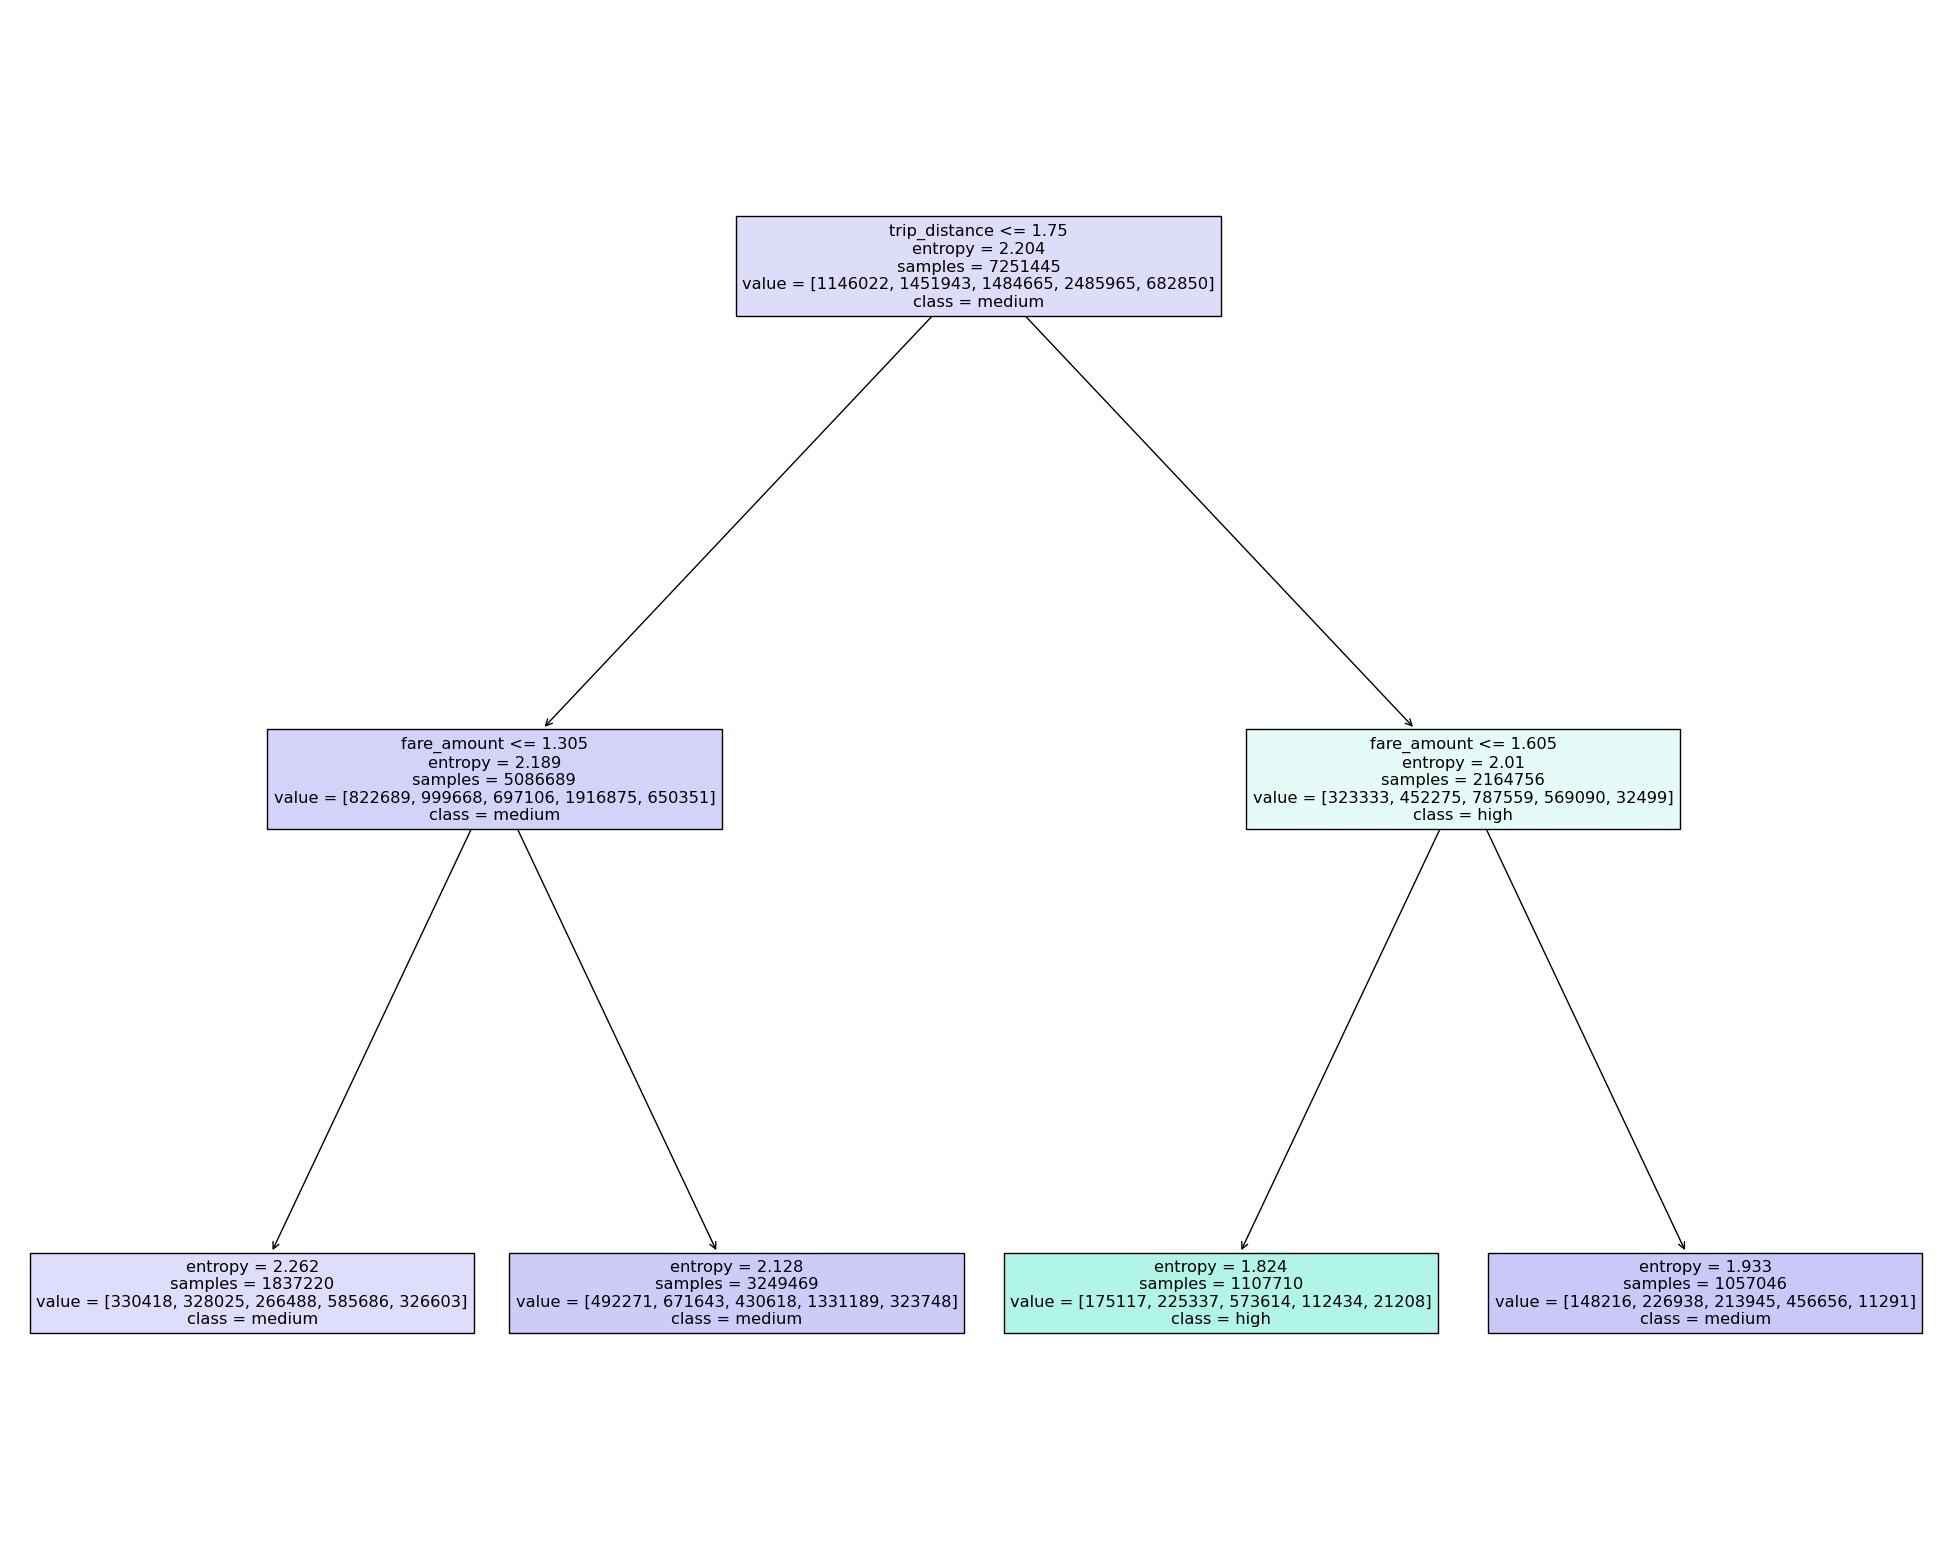

In [52]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(
    clf,
    feature_names=list(X),
    class_names=card_data_2019['tip_class'].values,
    filled=True
)

Konklúzió: Minden kipróbált esetben a döntési fa csak egy attribútumot használt fel a klaszzifikálásra, ha azt kivettük akkor is kizárólag csak egy másik attribútumot használt fel, a fa mélysége változtatásával is csak azt az attribútumot szedte szét kisebb intervallumokra, a többi attribútummal nem foglalkozott(A jelenlegi minta esetén ez az attr. a fare_amount). Ezt úgy értelmeztük, hogy nincsenek az attribútumoknak olyan értékeik amelyek mentén a borravaló nagysága erősen különbözik. Predikció során pedi azokat az értékeket prediktálja, amiből az alap mintában is alapból sok volt. 
(A modell mélysége növelhető, viszont így a fa ábrázolása szépen látszik, nagyobb mélységekben kevbésbé)

### COVID után(2020)

In [53]:
card_data_2020['tip_class'] = pd.qcut(
    card_data_2020['tip_amount'] / card_data_2020['total_amount'],
    5,
    labels=['low', 'low2', 'low3', 'medium', 'high']
)

C:\Users\Szilárd\AppData\Local\Temp\ipykernel_21416\2549200649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_data_2020['tip_class'] = pd.qcut(


In [54]:
X = card_data_2020.loc[:, ['trip_distance','extra','fare_amount','passenger_count']]
y = card_data_2020['tip_class']

In [55]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=1,stratify=y)

In [56]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

y_pred=clf.predict(X_test)

print("Training data accuracy:",round(clf.score(X_train,y_train),4))
print("Test data accuracy:",round(clf.score(X_test, y_test),4))


Training data accuracy: 0.4122
Test data accuracy: 0.4122


[Text(0.5, 0.8333333333333334, 'extra <= 1.75\nentropy = 2.224\nsamples = 2076777\nvalue = [365204, 417395, 417935, 675675, 200568]\nclass = medium'),
 Text(0.25, 0.5, 'fare_amount <= 7.18\nentropy = 2.188\nsamples = 1449198\nvalue = [256176, 286162, 175137, 541183, 190540]\nclass = medium'),
 Text(0.125, 0.16666666666666666, 'entropy = 2.267\nsamples = 491608\nvalue = [99251, 90318, 56686, 140228, 105125]\nclass = medium'),
 Text(0.375, 0.16666666666666666, 'entropy = 2.106\nsamples = 957590\nvalue = [156925, 195844, 118451, 400955, 85415]\nclass = medium'),
 Text(0.75, 0.5, 'fare_amount <= 9.575\nentropy = 2.012\nsamples = 627579\nvalue = [109028, 131233, 242798, 134492, 10028]\nclass = high'),
 Text(0.625, 0.16666666666666666, 'entropy = 1.717\nsamples = 361545\nvalue = [66975, 71300, 198054, 17749, 7467]\nclass = high'),
 Text(0.875, 0.16666666666666666, 'entropy = 1.924\nsamples = 266034\nvalue = [42053, 59933, 44744, 116743, 2561]\nclass = medium')]

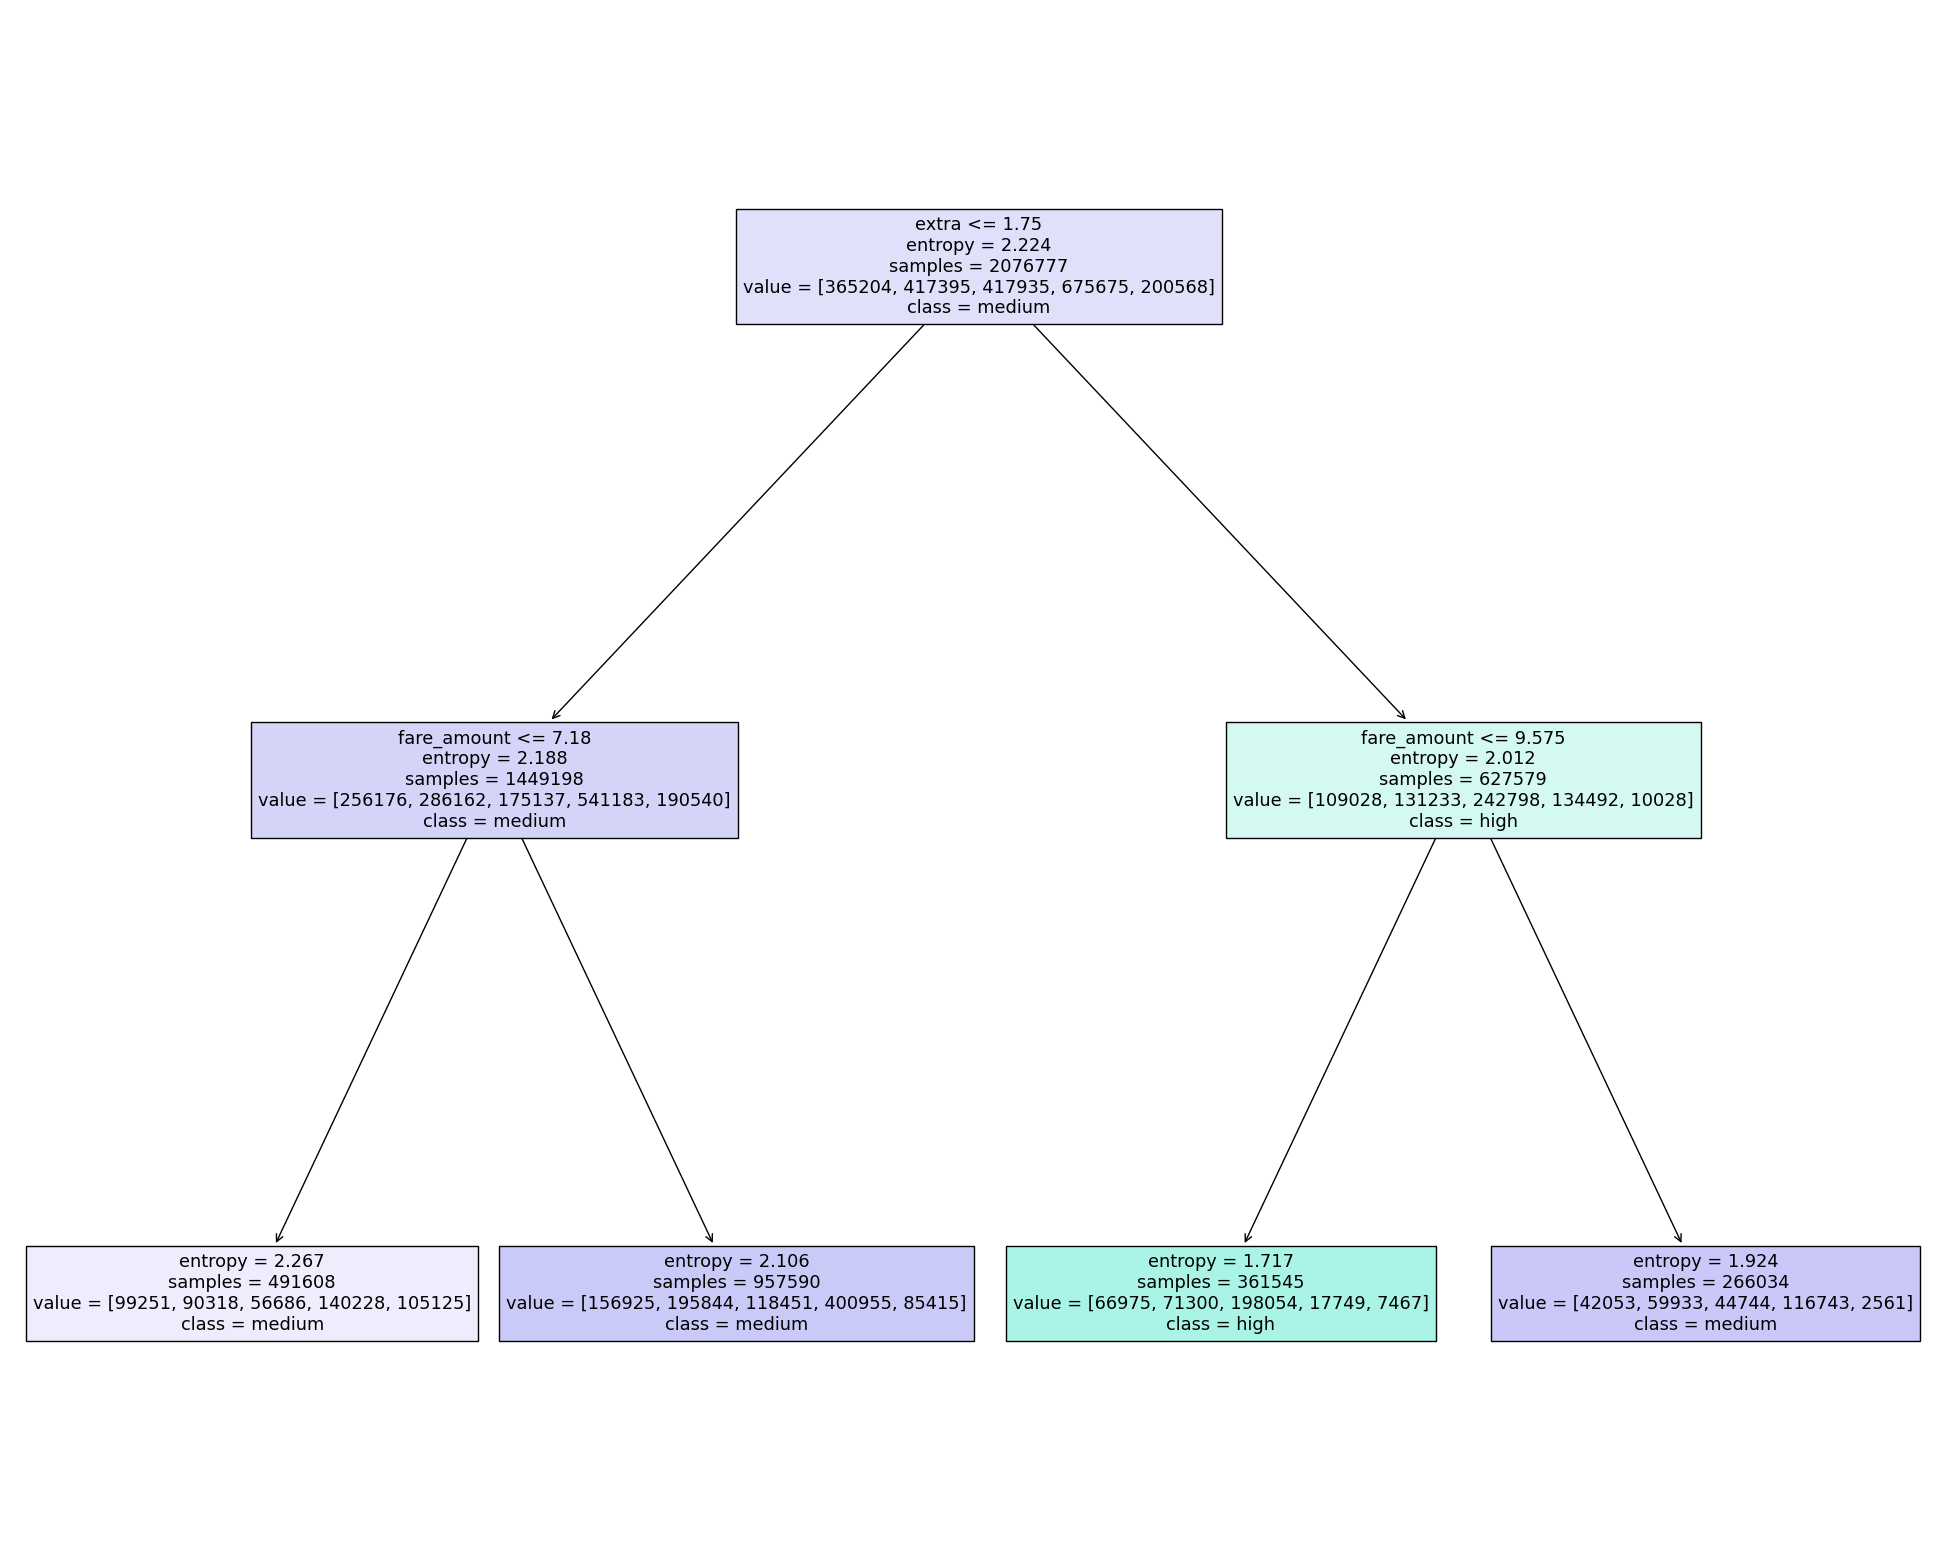

In [57]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(
    clf,
    feature_names=list(X),
    class_names=card_data_2019['tip_class'].values,
    filled=True
)

Nem vettünk észre különbéget a 2019-es és a 2020-as klasszifikáció során. 

## Összegzés
Az adatelemzés során megbizonyosodhattunk, hogy a New York-i sárga taxik használatára is észrevehető hatással voltak a COVID-lezárások. Azt is feljegyeztük, hogy a repterek és a belváros a részei leggyakrabban a taxiutaknak, ezeken a területeken volt a legnagyobb visszaesés is a COVID érkezésével a taxiutak számában, és mindezt vizuálisan is elemeztük. Kiszámoltuk, hogy jó becslés borravalóra a teljes költség függvényében annak 14%-a, és hogy különböző szabályszerűségek alapján adnak borravalót az utasok: a fix és a költséggel arányos két módja ezeknek.